In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

bkg = ObjIter([])
# bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 3/3 [00:10<00:00,  3.51s/it]


In [6]:

t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [7]:
(signal+bkg+data).apply(lambda t : eightb.load_yy_quadh_ranker(t, model=eightb.models.yy_quadh_bkg10_soft025_md.path))

[None, None, None]

100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


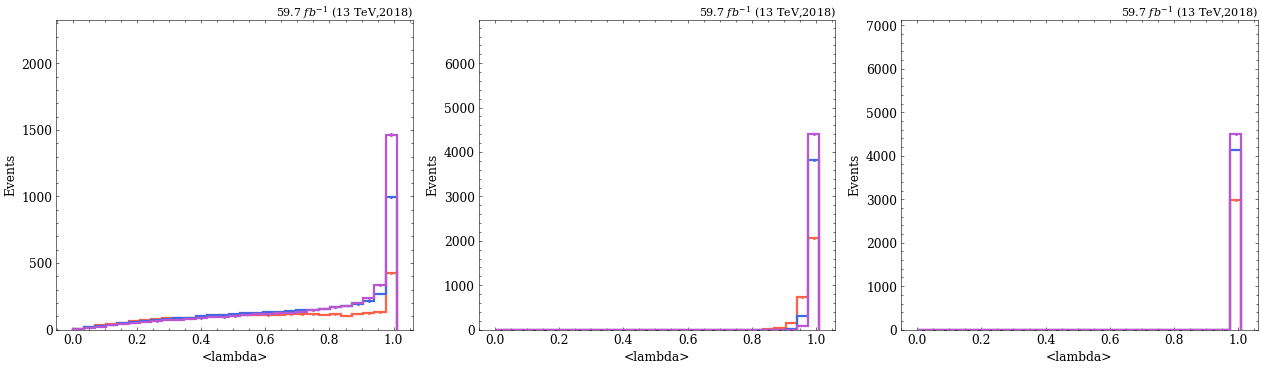

In [29]:
study.quick( 
    signal,
    varlist=[lambda t : ak.min(t.mass_rank[:,0],axis=-1), lambda t : ak.mean(t.mass_rank[:,0],axis=-1), lambda t : ak.max(t.mass_rank[:,0],axis=-1)],
    dim=-1,
    binlist=[(0,1.01,30)]*3
)

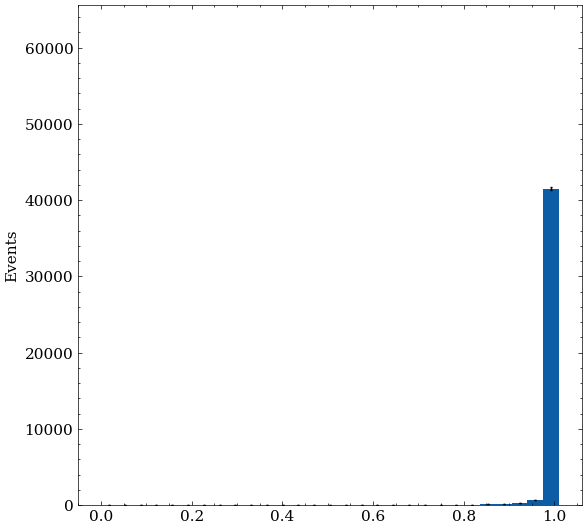

In [37]:
_,_, h = histo_array(signal[0].mass_rank[:,:,0], bins=np.linspace(0,1.01,30))

100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


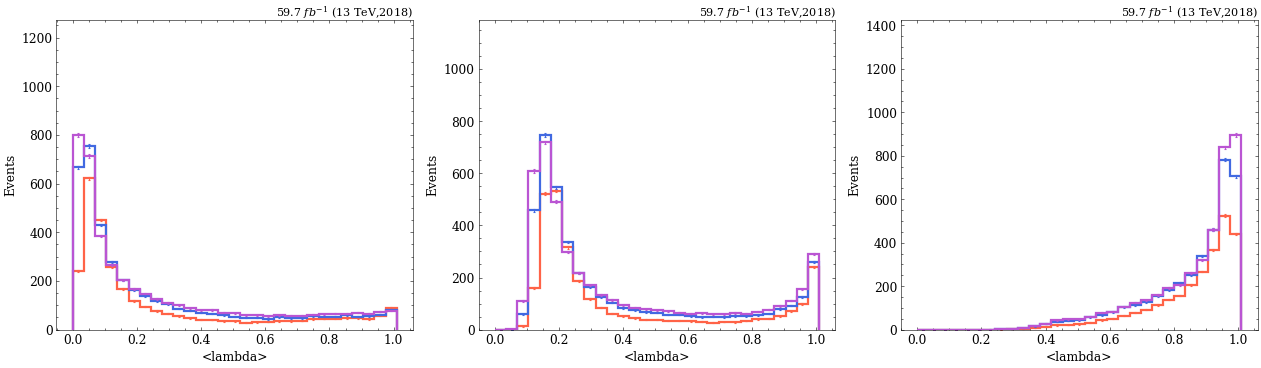

In [30]:
study.quick( 
    signal,
    varlist=[lambda t : ak.min(t.nn_rank[:,0],axis=-1), lambda t : ak.mean(t.nn_rank[:,0],axis=-1), lambda t : ak.max(t.nn_rank[:,0],axis=-1)],
    dim=-1,
    binlist=[(0,1.01,30)]*3
)

100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


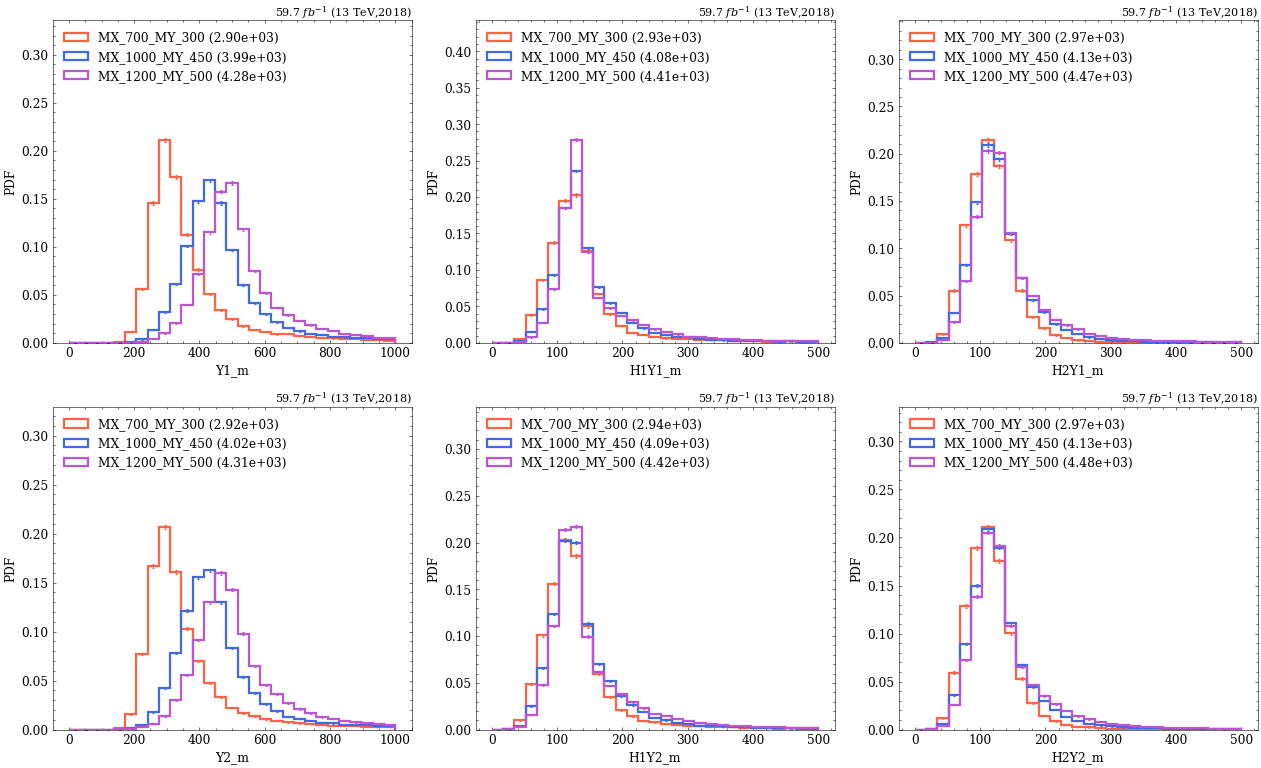

In [8]:
study.quick( 
    signal+bkg,
    legend=True,
    efficiency=True,
    varlist=['Y1_m','H1Y1_m','H2Y1_m','Y2_m','H1Y2_m','H2Y2_m'],
    binlist=[(0,1000,30),(0,500,30),(0,500,30)]*2
)

100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


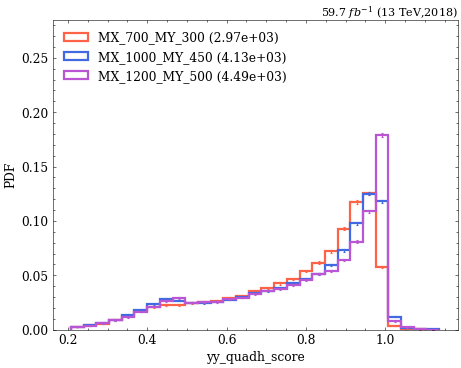

In [9]:
study.quick( 
    signal+bkg,
    legend=True,
    efficiency=True,
    varlist=['yy_quadh_score']
)

100%|██████████| 6/6 [00:00<00:00, 14.70it/s]


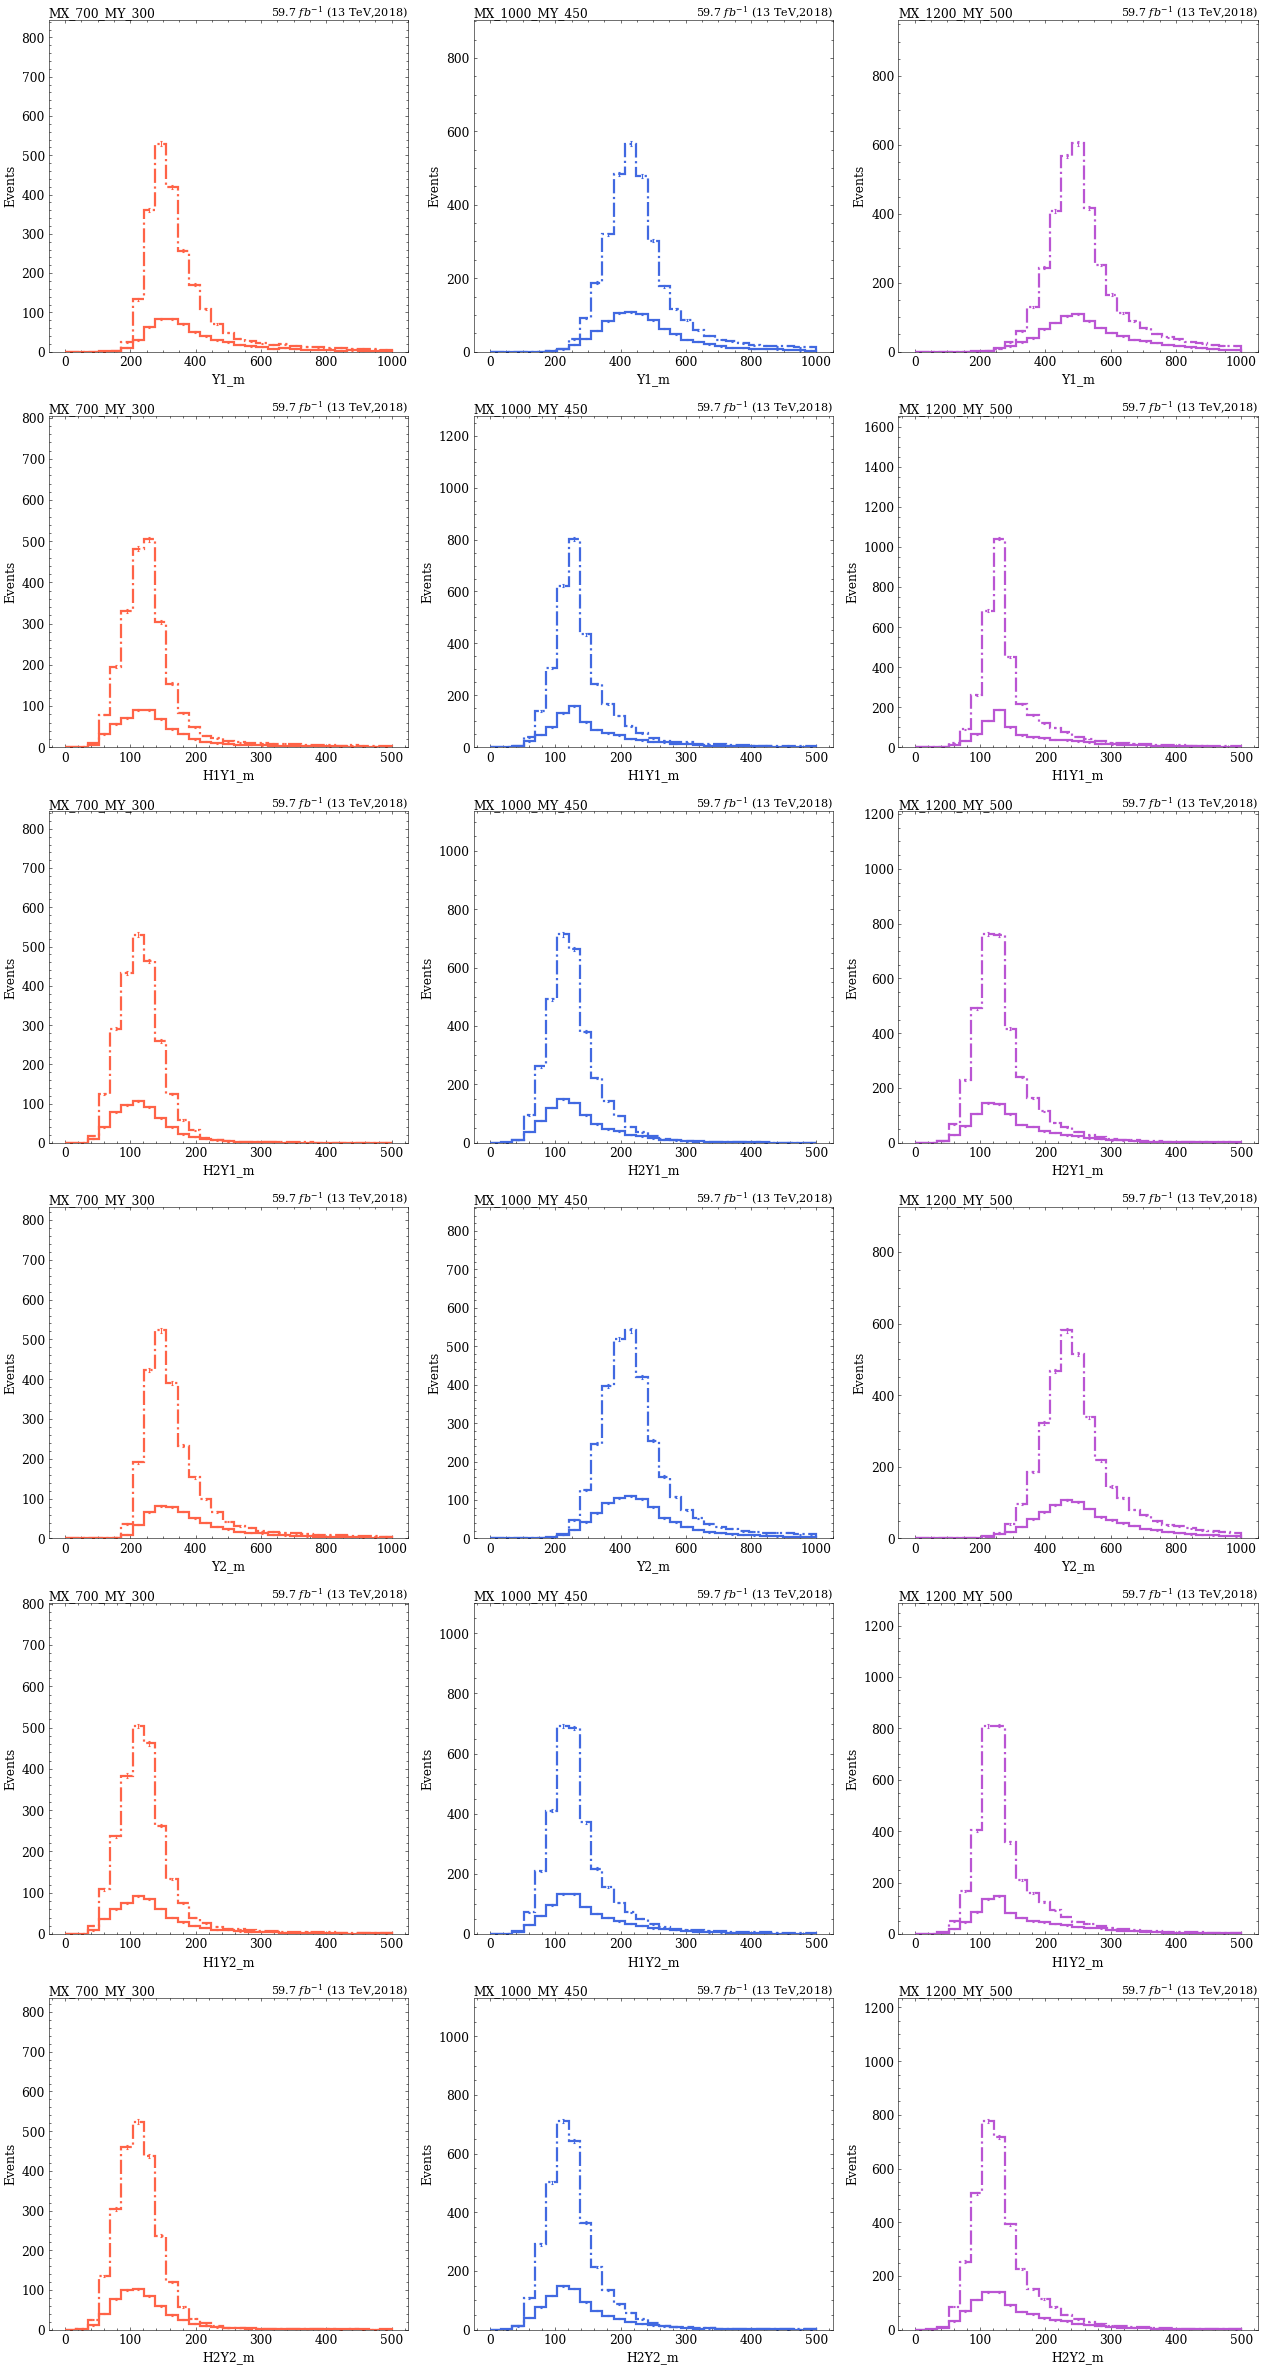

In [11]:
study.compare_masks(
    signal,
    # bkg,
    masks=[lambda t:t.yy_quadh_score < 0.6,lambda t:t.yy_quadh_score > 0.6],
    varlist=['Y1_m','H1Y1_m','H2Y1_m','Y2_m','H1Y2_m','H2Y2_m'],
    binlist=[(0,1000,30),(0,500,30),(0,500,30)]*2

)

100%|██████████| 6/6 [00:00<00:00, 11.84it/s]


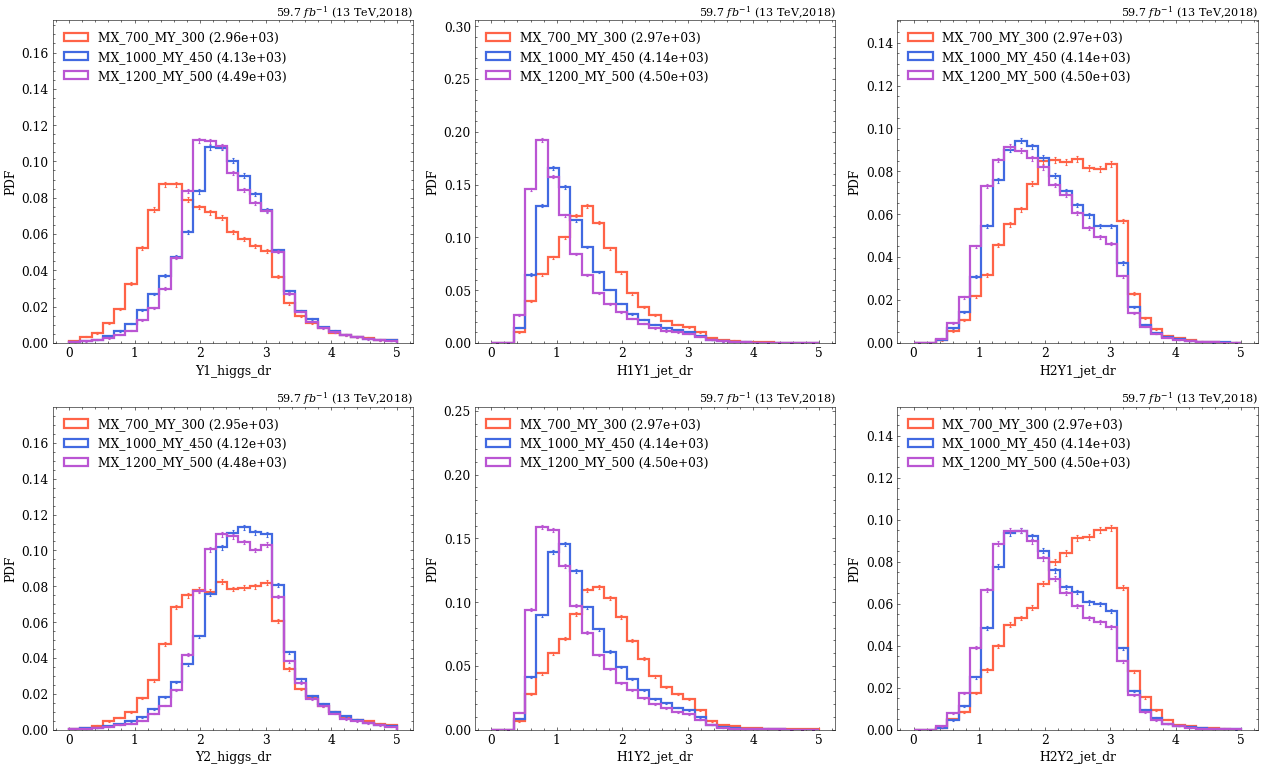

In [12]:
study.quick( 
    signal+bkg,
    legend=True,
    efficiency=True,
    varlist=['Y1_higgs_dr','H1Y1_jet_dr','H2Y1_jet_dr','Y2_higgs_dr','H1Y2_jet_dr','H2Y2_jet_dr'],
    binlist=[(0,5,30)]*6
)

100%|██████████| 6/6 [00:00<00:00, 16.96it/s]


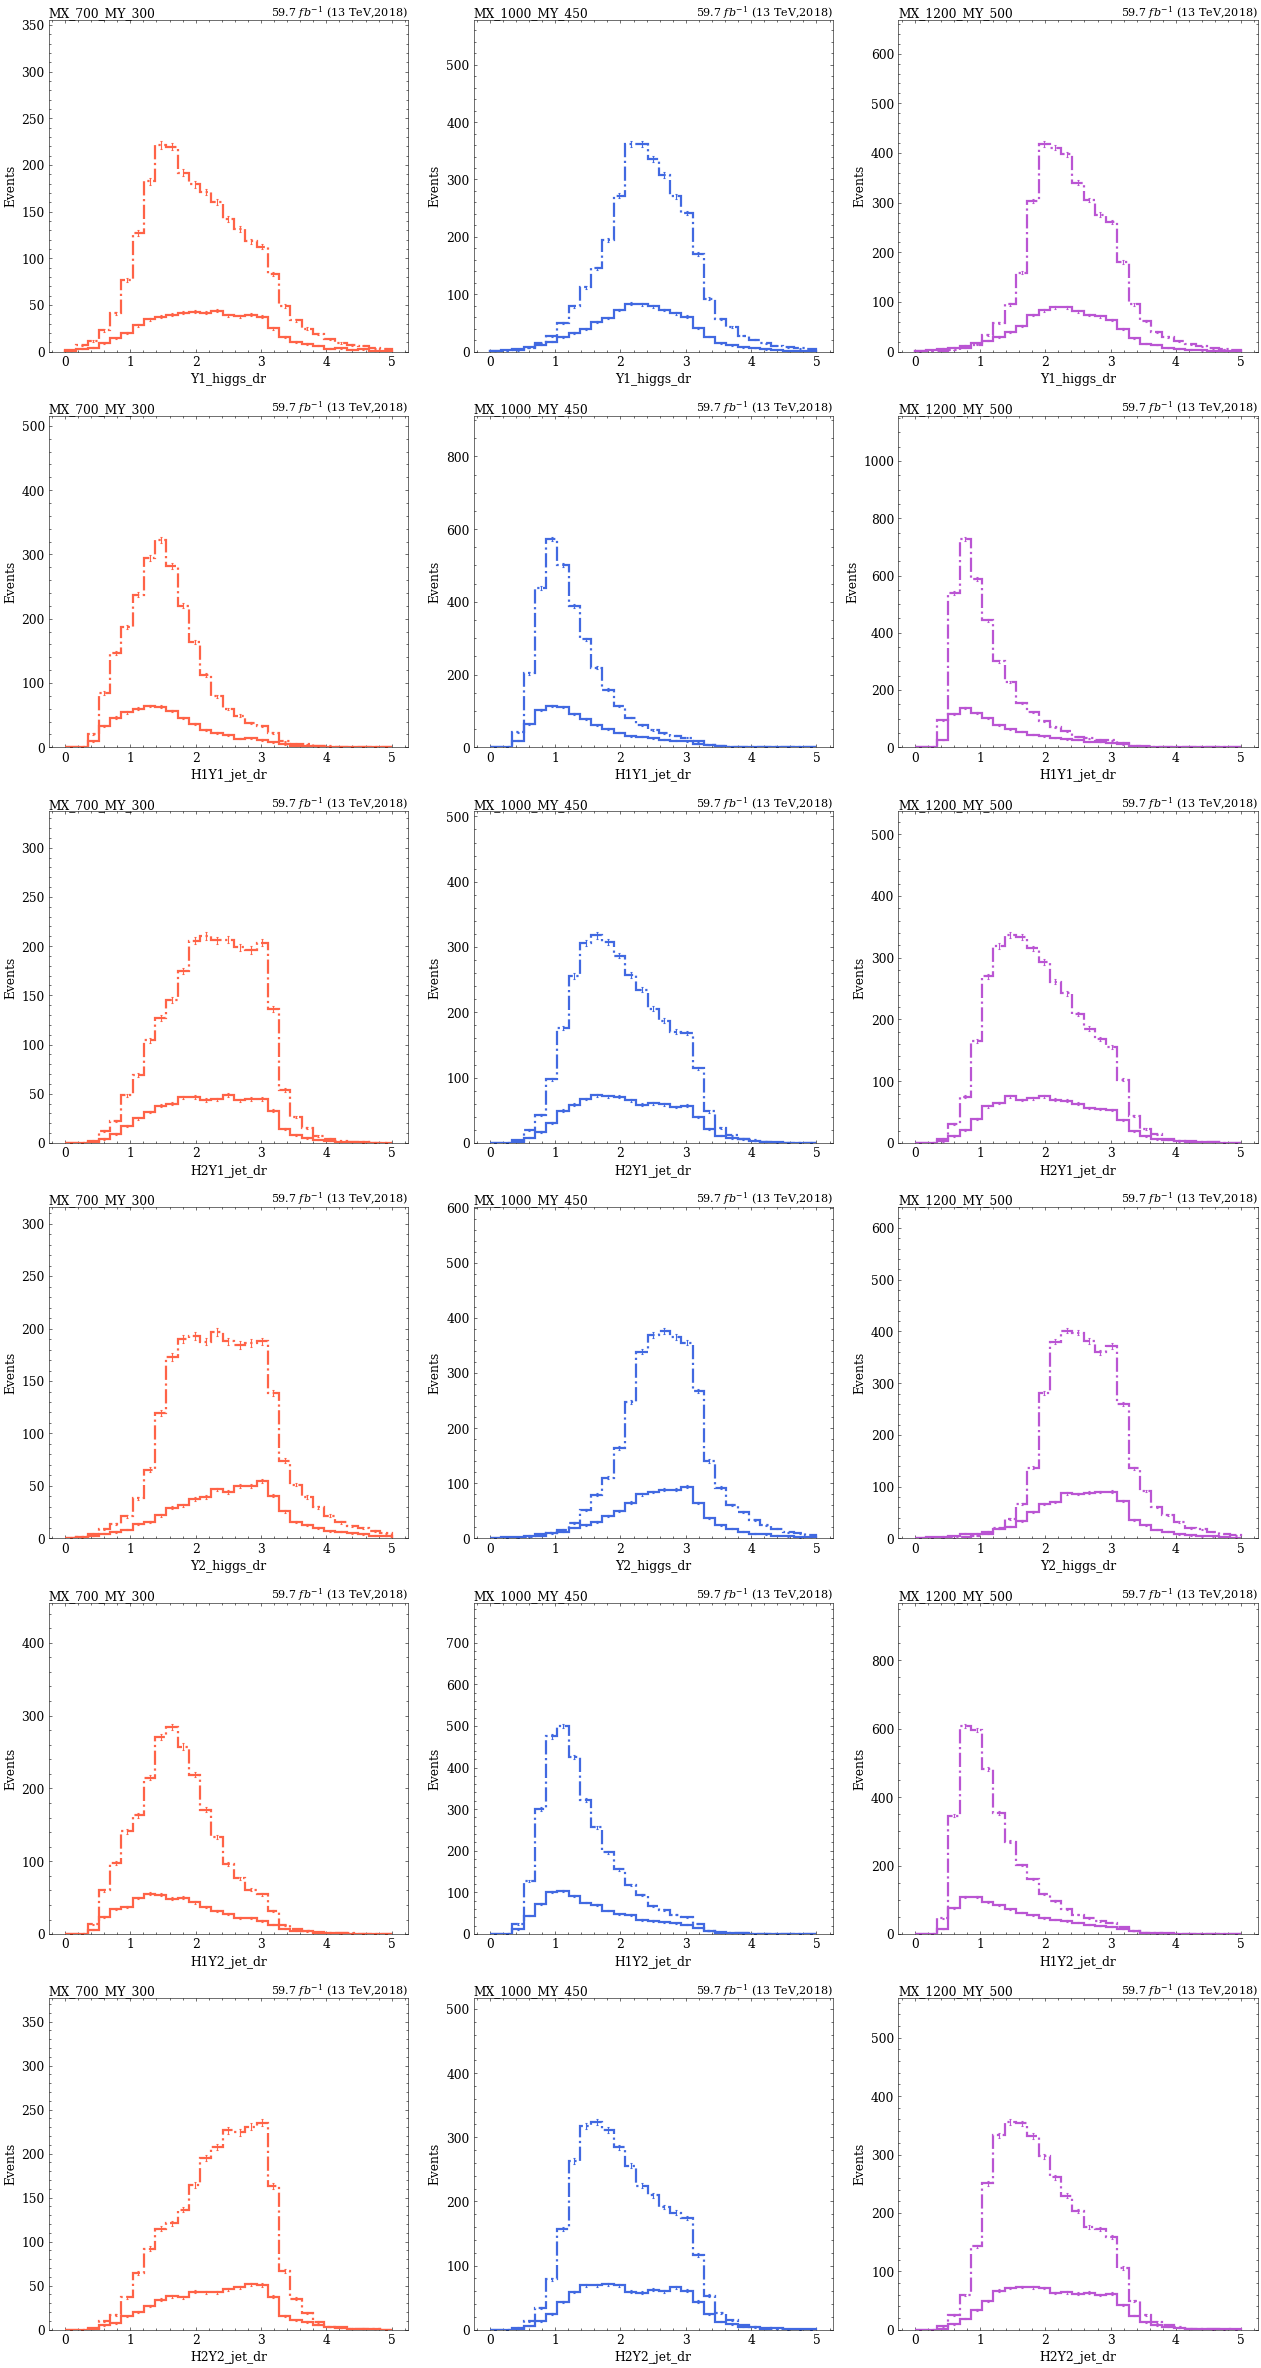

In [13]:
study.compare_masks(
    signal,
    # bkg,
    masks=[lambda t:t.yy_quadh_score < 0.6,lambda t:t.yy_quadh_score > 0.6],
    varlist=['Y1_higgs_dr','H1Y1_jet_dr','H2Y1_jet_dr','Y2_higgs_dr','H1Y2_jet_dr','H2Y2_jet_dr'],
    binlist=[(0,5,30)]*6

)